# RDD: Find discontinuities caused by a global event

## 1. Basics 

Import libraries

In [14]:
%matplotlib inline

from datetime import datetime, timedelta
import scipy.stats
import codecs                     # load UTF-8 Content
import json                       # load JSON files
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
from dateutil import *            # I prefer dateutil for parsing dates
import math                       # transformations
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter   # Counter is useful for grouping and counting
import scipy
from patsy import dmatrices
import statsmodels.formula.api as sm

Set global variables

In [15]:
N=7                          # the period, in days, before and after the event we are interested in
COUNTRY_OF_INTEREST = 'US'     # for which country we want to do the data analysis


Set global functions

In [16]:
def read_events(a_file):
    events = pd.read_csv(a_file, sep=",", names=['id', 'description', 'year', 'month', 'day', 'category'])
    return events

## 2. Load event data

We load the events in a Pandas dataframe and create a new column that contains the date in one cell. The date is converted to datetime in order to make future processing easier. As we only have music data up till 2015, we filter out all the events after 01/01/2015.


---------------------------------------------------------

Preview of the dataset

    id        description  year  month  day category       date
60  60           iPhone 6  2014      9    9     tech 2014-09-09
61  61  Samsung Galaxy S5  2014      2   25     tech 2014-02-25
62  62            Nexus 6  2014     10   16     tech 2014-10-16
63  63             Moto G  2014     11   28     tech 2014-11-28
64  64     Samsung Note 4  2014      8   31     tech 2014-08-31

---------------------------------------------------------

Total number of events: 168

---------------------------------------------------------

Visual overview of events



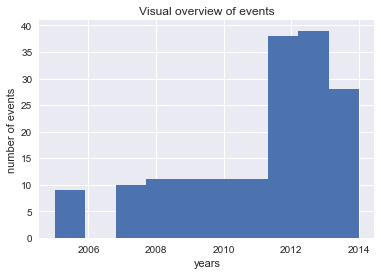

In [17]:
events = read_events("../data/events.csv")

# The dataset has the year, month, and day in three different cells. We would like to have this information in one cell
dates = []
for index, row in events.iterrows():
    date = str(events.iloc[index]['year']) + "-" + str(events.iloc[index]['month']) + "-" + str(events.iloc[index]['day'])
    dates.append(date)

# CREATE A NEW DATA FRAME AND MERGE WITH EVENT DATA FRAME
df2 = pd.DataFrame(dates, columns=['date'])
events = pd.concat([events, df2], axis=1)
events['date'] = pd.to_datetime(events['date'], format='%Y-%m-%d')

# Drop duplicates
events.drop_duplicates(subset=['description', 'date'], keep='first', inplace=True)

# APPLY FILTER TO EVENT DATA FRAME
events_filtered = events[(events['year'] < 2015)]

print('')
print('---------------------------------------------------------')
print('')

print('Preview of the dataset')
print('')

print(events_filtered.head())

print('')
print('---------------------------------------------------------')
print('')

print('Total number of events: %s' % len(list(events_filtered.description)))

print('')
print('---------------------------------------------------------')
print('')

print('Visual overview of events')
print('')

plt.hist(list(events_filtered.year))

plt.title('Visual overview of events')
plt.xlabel('years')
plt.ylabel('number of events')

## 3. Load the Listening data

We load a dataframe that contains the absolute and relative playcount per genre for each country on a daily basis. From the t-test, we know that the seasonal component might cause the number of listening events going up or down after an event, but have no relation with the event itself. Therefore, we load a dataframe that also has a column that subtracts the seasonal component from the original signal.

In [18]:
df = pd.DataFrame(json.load(open("../data/data_rel_playcount_artist.json")))
df['date'] = pd.to_datetime(df['week'], format='%Y-%m-%d')
df['relative_play'] = df['relative_play'].astype('float64')
df['playcount'] = df['playcount'].astype('float64')

# FILTER COUNTRIES
df_filter = df[(df.country == COUNTRY_OF_INTEREST)]
df_filter.set_index('date', inplace=True)
print(df_filter.head())

                           artist country  playcount  relative_play  \
date                                                                  
2005-01-01  Red Hot Chili Peppers      US        2.0       0.200000   
2005-02-14  Red Hot Chili Peppers      US        2.0       0.250000   
2005-02-15  Red Hot Chili Peppers      US        1.0       0.142857   
2005-02-19  Red Hot Chili Peppers      US        2.0       0.117647   
2005-02-20  Red Hot Chili Peppers      US        3.0       0.166667   

                 week  year  
date                         
2005-01-01   2005-1-1  2005  
2005-02-14  2005-2-14  2005  
2005-02-15  2005-2-15  2005  
2005-02-19  2005-2-19  2005  
2005-02-20  2005-2-20  2005  


Furthermore, we load a dataframe that contains the number of unqique listeners per day. This number follows from the listen event file and is used to calculate the number of songs listened per user.

In [19]:
unqiue_listeners_per_day = pd.DataFrame(json.load(open("../data/unique_users_per_day.json")))
unqiue_listeners_per_day['date'] = pd.to_datetime(unqiue_listeners_per_day['date'], format='%Y-%m-%d')
unqiue_listeners_per_day.set_index('date', inplace=True)
unqiue_listeners_per_day.sort_index(inplace=True)

print('')
print('---------------------------------------------------------')
print('')

print('Preview of the dataset')
print('')
print(unqiue_listeners_per_day.head())

print('')
print('---------------------------------------------------------')
print('')

print('Number of days for which we have unique listeners: %s' % len(list(unqiue_listeners_per_day['number_of_unqiue_listeners'])))

print('')
print('---------------------------------------------------------')
print('')




---------------------------------------------------------

Preview of the dataset

            number_of_unqiue_listeners
date                                  
1970-01-01                           2
2005-02-14                          73
2005-02-15                          77
2005-02-16                          75
2005-02-17                          68

---------------------------------------------------------

Number of days for which we have unique listeners: 3493

---------------------------------------------------------



We concatinate both the event and unqiue user dataframe, and add a new column that devides the playcount through the number of unqiue users. We do this eliminate an effect possible caused by the number of users that listen.

In [ ]:
DF = df_filter
print(DF.head())


                           artist country  playcount  relative_play  \
date                                                                  
2005-01-01  Red Hot Chili Peppers      US        2.0       0.200000   
2005-02-14  Red Hot Chili Peppers      US        2.0       0.250000   
2005-02-15  Red Hot Chili Peppers      US        1.0       0.142857   
2005-02-19  Red Hot Chili Peppers      US        2.0       0.117647   
2005-02-20  Red Hot Chili Peppers      US        3.0       0.166667   

                 week  year  
date                         
2005-01-01   2005-1-1  2005  
2005-02-14  2005-2-14  2005  
2005-02-15  2005-2-15  2005  
2005-02-19  2005-2-19  2005  
2005-02-20  2005-2-20  2005  


From the t-test, we saw that changes between the the data group before and after the event where often caused by a higher level trend. However, even in this trend the event might have an impact which should result in a discontinuity of the regression at the day of the event.

The Forcing Variable (csize) is centered around the cutoff, and the cutoff predictor (small) is a dichotomous variable that indicates which side of the cutoff an observation lands.

/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/eelcowiechert/anacona36/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu


---------------------------------------------------------

R-squared: 0.551200479848

---------------------------------------------------------

Parameters

Intercept                  0.758572
threshold                 -0.633851
days_to_event              0.065241
threshold:days_to_event   -0.046171
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.001060
threshold                  0.014311
days_to_event              0.110749
threshold:days_to_event    0.401817
dtype: float64

---------------------------------------------------------



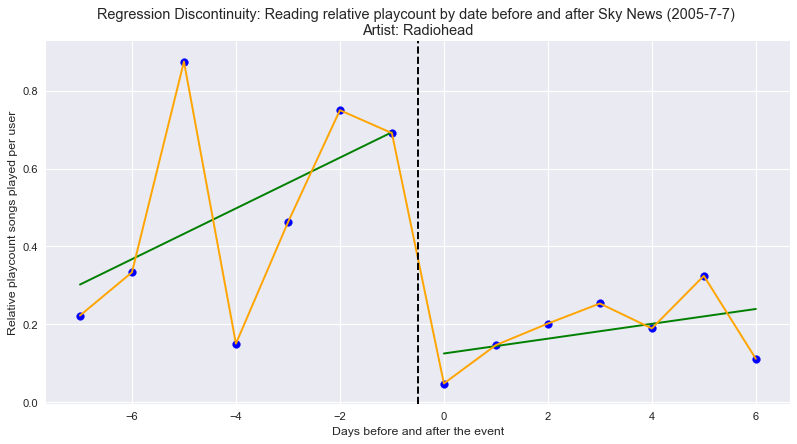


---------------------------------------------------------

R-squared: 0.878258982935

---------------------------------------------------------

Parameters

Intercept                  0.003933
threshold                  0.025152
days_to_event             -0.009640
threshold:days_to_event    0.009798
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.520766
threshold                  0.010070
days_to_event              0.000044
threshold:days_to_event    0.001260
dtype: float64

---------------------------------------------------------



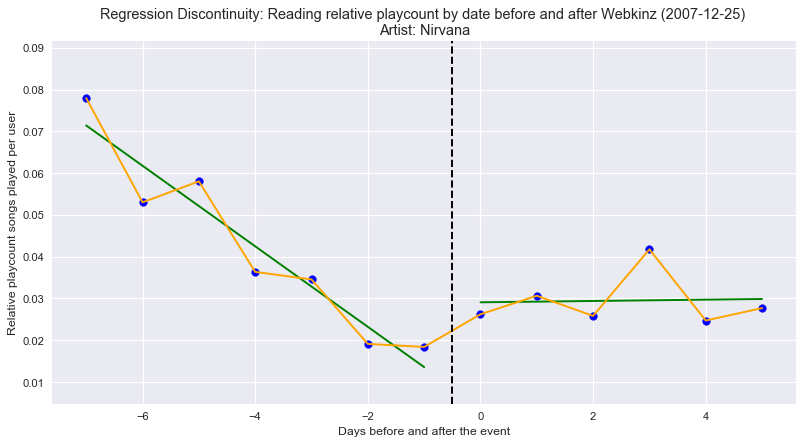


---------------------------------------------------------

R-squared: 0.547408939046

---------------------------------------------------------

Parameters

Intercept                  0.015421
threshold                  0.081650
days_to_event             -0.002851
threshold:days_to_event   -0.006749
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.579547
threshold                  0.033691
days_to_event              0.625051
threshold:days_to_event    0.399450
dtype: float64

---------------------------------------------------------



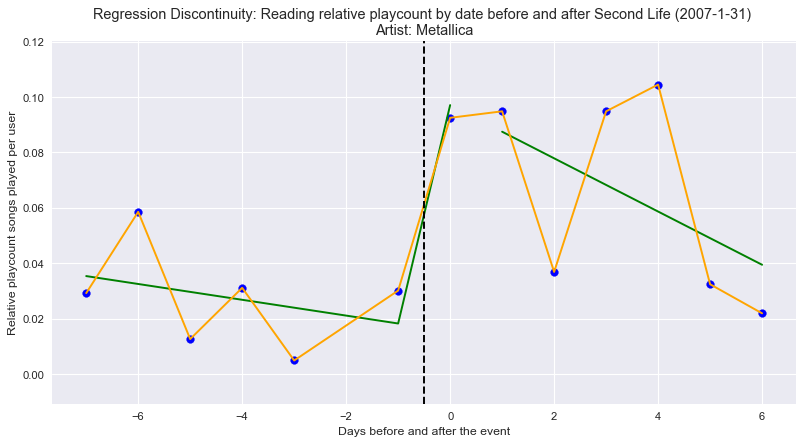


---------------------------------------------------------

R-squared: 0.542211830636

---------------------------------------------------------

Parameters

Intercept                  0.201202
threshold                 -0.163925
days_to_event              0.019107
threshold:days_to_event   -0.012972
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.001169
threshold                  0.017889
days_to_event              0.078651
threshold:days_to_event    0.425319
dtype: float64

---------------------------------------------------------



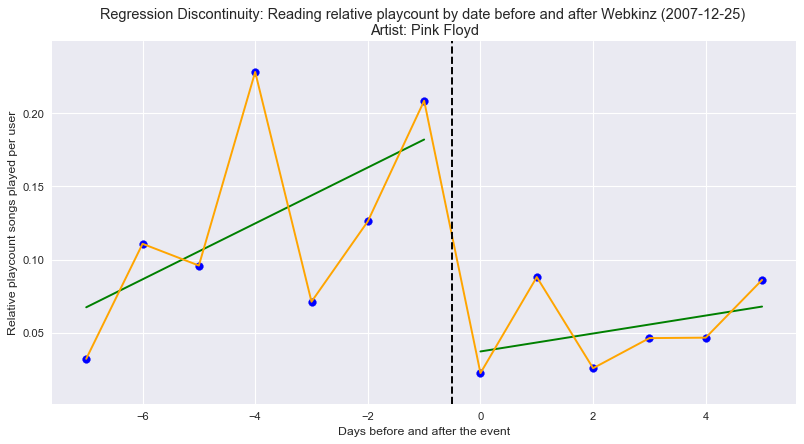


---------------------------------------------------------

R-squared: 0.730247446164

---------------------------------------------------------

Parameters

Intercept                  0.065175
threshold                  0.144495
days_to_event             -0.002072
threshold:days_to_event   -0.023992
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.045650
threshold                  0.002783
days_to_event              0.752271
threshold:days_to_event    0.024055
dtype: float64

---------------------------------------------------------



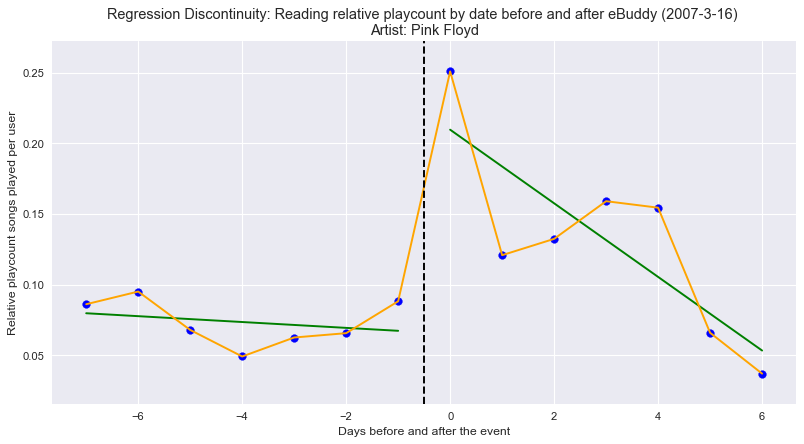


---------------------------------------------------------

R-squared: 0.591346534275

---------------------------------------------------------

Parameters

Intercept                  0.007976
threshold                  0.017572
days_to_event             -0.000283
threshold:days_to_event   -0.002357
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.122023
threshold                  0.015897
days_to_event              0.794237
threshold:days_to_event    0.145524
dtype: float64

---------------------------------------------------------



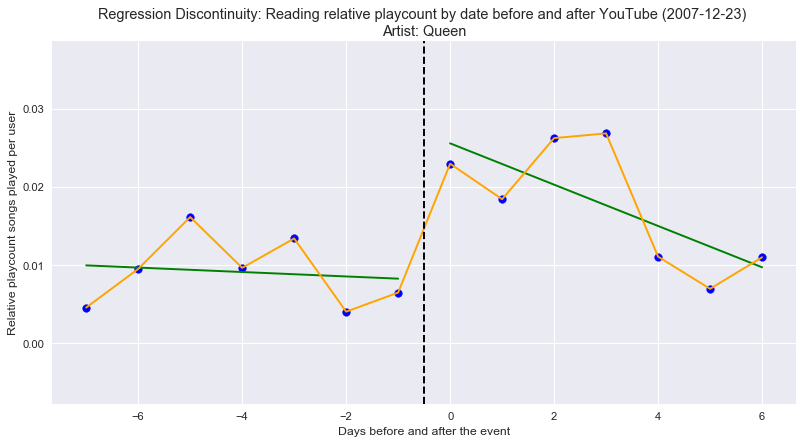


---------------------------------------------------------

R-squared: 0.539012038108

---------------------------------------------------------

Parameters

Intercept                  0.346170
threshold                 -0.197725
days_to_event              0.052002
threshold:days_to_event   -0.057318
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.000492
threshold                  0.048187
days_to_event              0.006780
threshold:days_to_event    0.024341
dtype: float64

---------------------------------------------------------



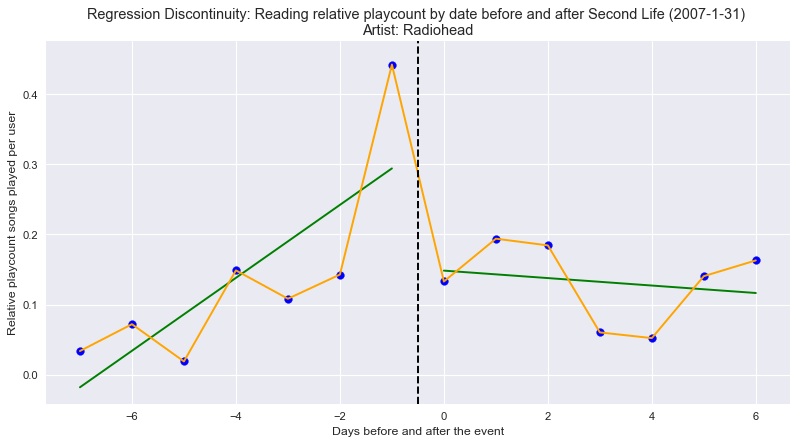


---------------------------------------------------------

R-squared: 0.920278080928

---------------------------------------------------------

Parameters

Intercept                 -0.021561
threshold                  0.086139
days_to_event             -0.028285
threshold:days_to_event    0.019535
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.273498
threshold                  0.004797
days_to_event              0.000080
threshold:days_to_event    0.005963
dtype: float64

---------------------------------------------------------



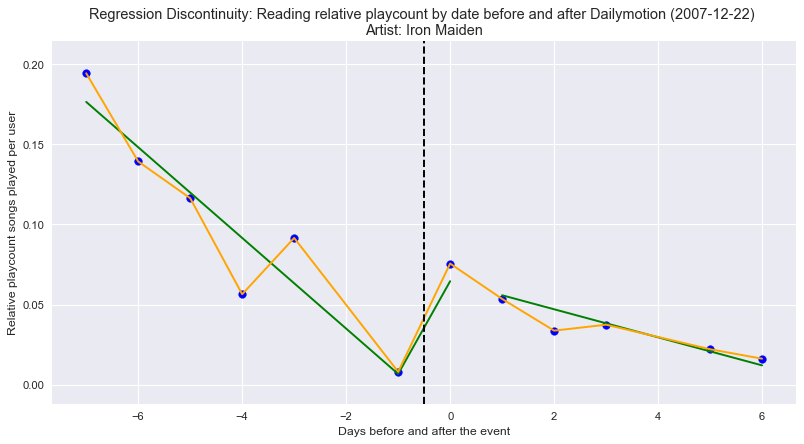


---------------------------------------------------------

R-squared: 0.920278080928

---------------------------------------------------------

Parameters

Intercept                 -0.021561
threshold                  0.086139
days_to_event             -0.028285
threshold:days_to_event    0.019535
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.273498
threshold                  0.004797
days_to_event              0.000080
threshold:days_to_event    0.005963
dtype: float64

---------------------------------------------------------



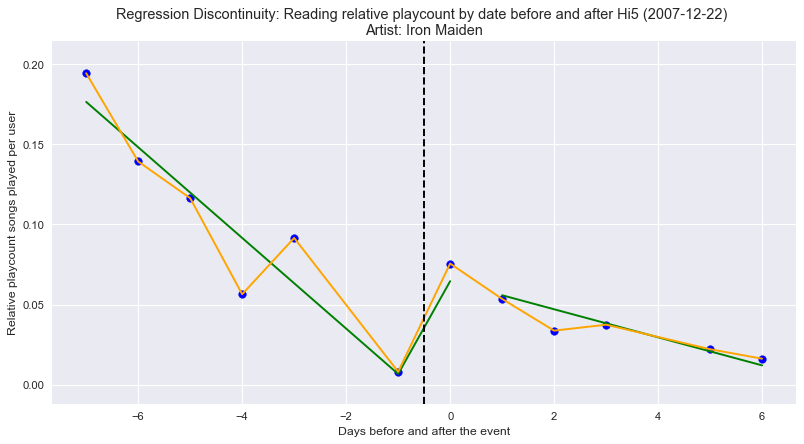


---------------------------------------------------------

R-squared: 0.920278080928

---------------------------------------------------------

Parameters

Intercept                 -0.021561
threshold                  0.086139
days_to_event             -0.028285
threshold:days_to_event    0.019535
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.273498
threshold                  0.004797
days_to_event              0.000080
threshold:days_to_event    0.005963
dtype: float64

---------------------------------------------------------



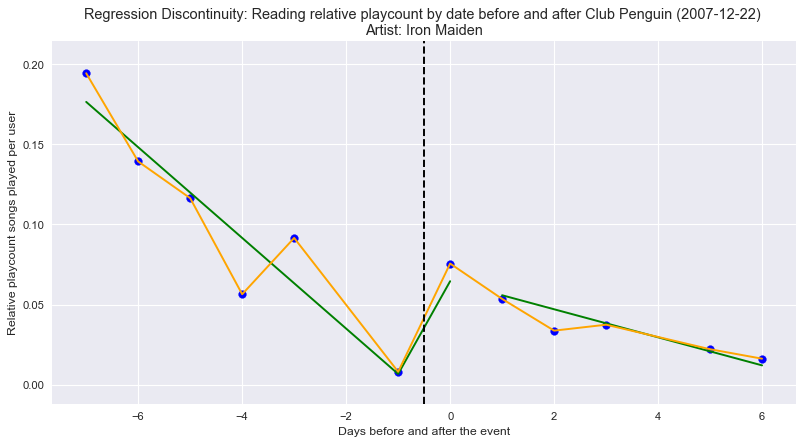


---------------------------------------------------------

R-squared: 0.621565095148

---------------------------------------------------------

Parameters

Intercept                  0.015852
threshold                  0.028225
days_to_event             -0.006033
threshold:days_to_event    0.002532
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.078579
threshold                  0.021735
days_to_event              0.007569
threshold:days_to_event    0.345801
dtype: float64

---------------------------------------------------------



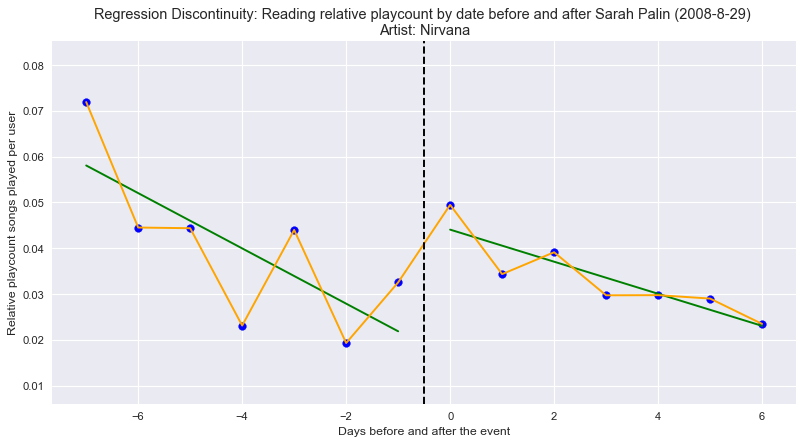


---------------------------------------------------------

R-squared: 0.714481165694

---------------------------------------------------------

Parameters

Intercept                  0.320711
threshold                 -0.166239
days_to_event              0.030791
threshold:days_to_event   -0.049535
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.000032
threshold                  0.016478
days_to_event              0.012027
threshold:days_to_event    0.005902
dtype: float64

---------------------------------------------------------



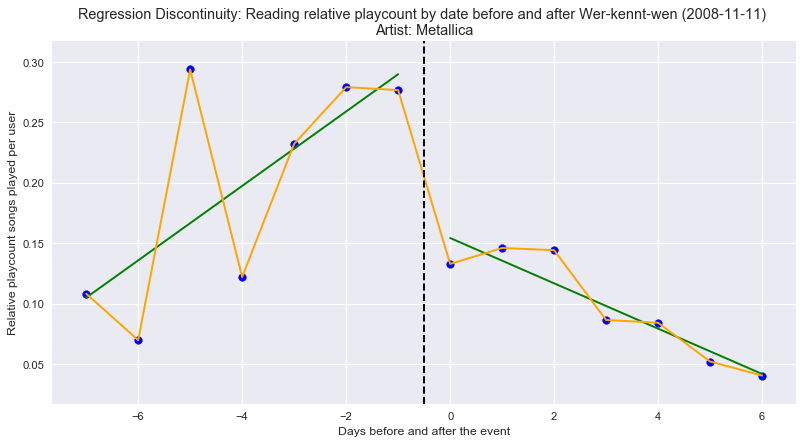


---------------------------------------------------------

R-squared: 0.658915684816

---------------------------------------------------------

Parameters

Intercept                  0.054386
threshold                  0.194498
days_to_event             -0.002484
threshold:days_to_event   -0.028062
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.261650
threshold                  0.007850
days_to_event              0.812893
threshold:days_to_event    0.080924
dtype: float64

---------------------------------------------------------



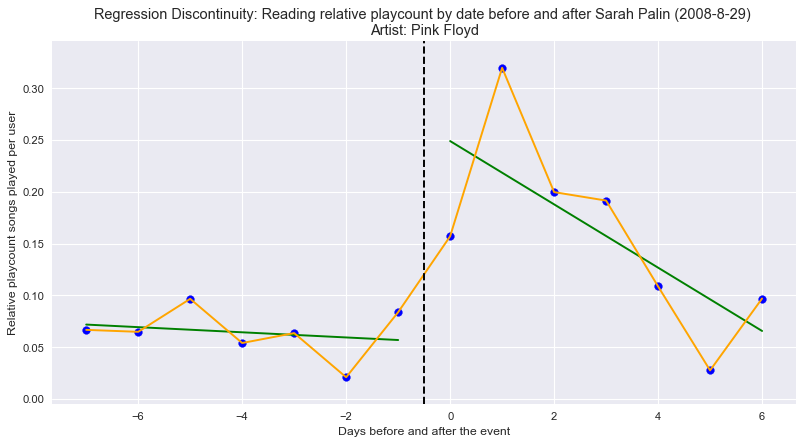


---------------------------------------------------------

R-squared: 0.534826464658

---------------------------------------------------------

Parameters

Intercept                  0.022188
threshold                  0.206873
days_to_event             -0.012429
threshold:days_to_event   -0.000759
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.718422
threshold                  0.022608
days_to_event              0.374655
threshold:days_to_event    0.968803
dtype: float64

---------------------------------------------------------



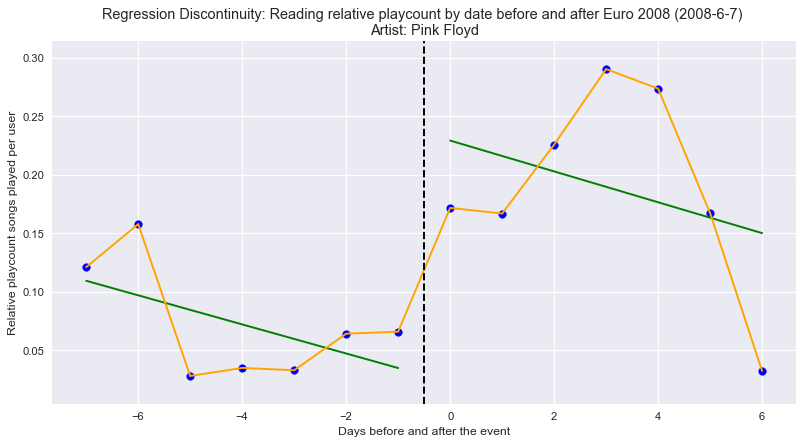


---------------------------------------------------------

R-squared: 0.537595152708

---------------------------------------------------------

Parameters

Intercept                 -0.005439
threshold                  0.030302
days_to_event             -0.007207
threshold:days_to_event    0.006338
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.618749
threshold                  0.047704
days_to_event              0.010994
threshold:days_to_event    0.075921
dtype: float64

---------------------------------------------------------



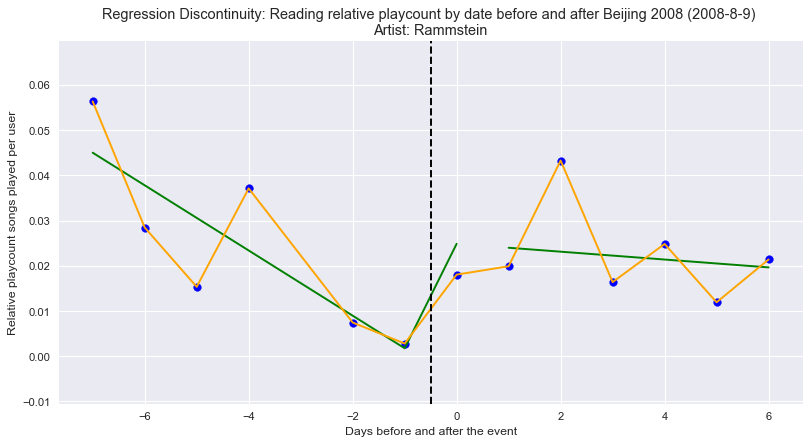


---------------------------------------------------------

R-squared: 0.537595152708

---------------------------------------------------------

Parameters

Intercept                 -0.005439
threshold                  0.030302
days_to_event             -0.007207
threshold:days_to_event    0.006338
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.618749
threshold                  0.047704
days_to_event              0.010994
threshold:days_to_event    0.075921
dtype: float64

---------------------------------------------------------



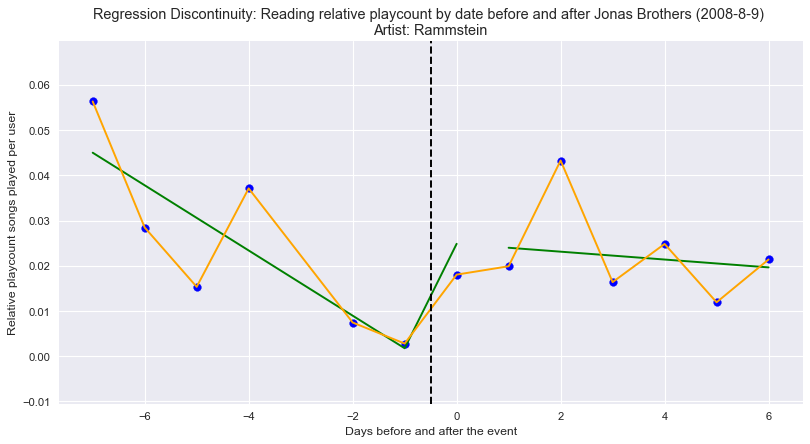


---------------------------------------------------------

R-squared: 0.867552119742

---------------------------------------------------------

Parameters

Intercept                  0.467220
threshold                 -0.289749
days_to_event              0.051371
threshold:days_to_event   -0.022661
dtype: float64

---------------------------------------------------------

P-values

Intercept                  5.287825e-08
threshold                  4.013773e-05
days_to_event              3.438786e-05
threshold:days_to_event    5.212677e-02
dtype: float64

---------------------------------------------------------



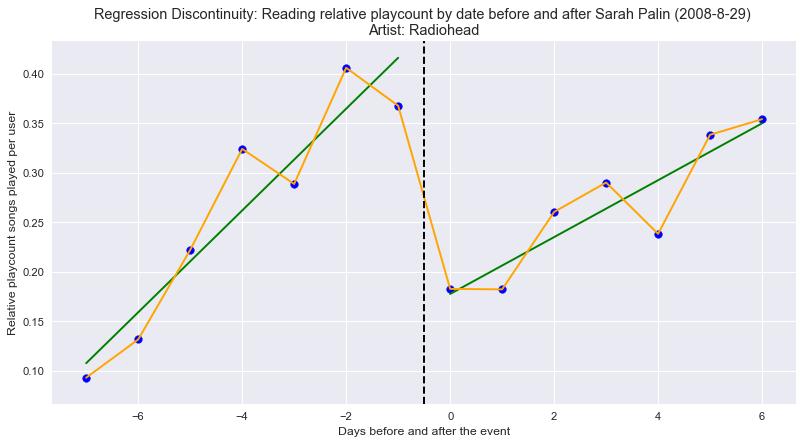


---------------------------------------------------------

R-squared: 0.433310812639

---------------------------------------------------------

Parameters

Intercept                  0.120121
threshold                 -0.073825
days_to_event              0.012160
threshold:days_to_event   -0.012313
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.000626
threshold                  0.041148
days_to_event              0.050978
threshold:days_to_event    0.143553
dtype: float64

---------------------------------------------------------



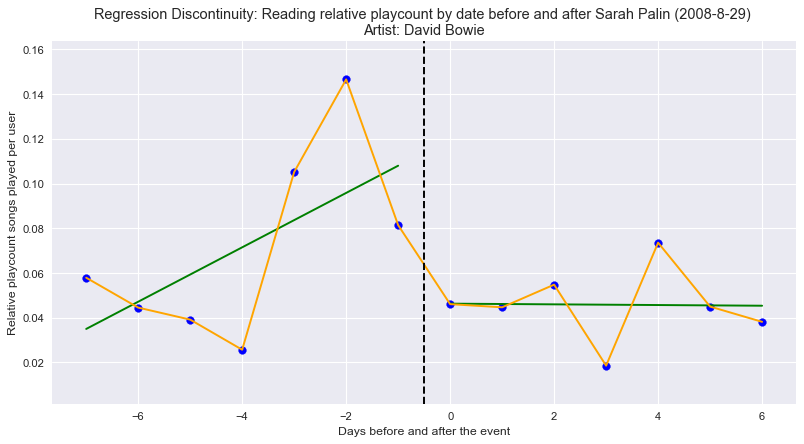


---------------------------------------------------------

R-squared: 0.56797000378

---------------------------------------------------------

Parameters

Intercept                  0.018677
threshold                  0.077074
days_to_event             -0.010134
threshold:days_to_event    0.005485
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.295408
threshold                  0.005295
days_to_event              0.023122
threshold:days_to_event    0.329367
dtype: float64

---------------------------------------------------------



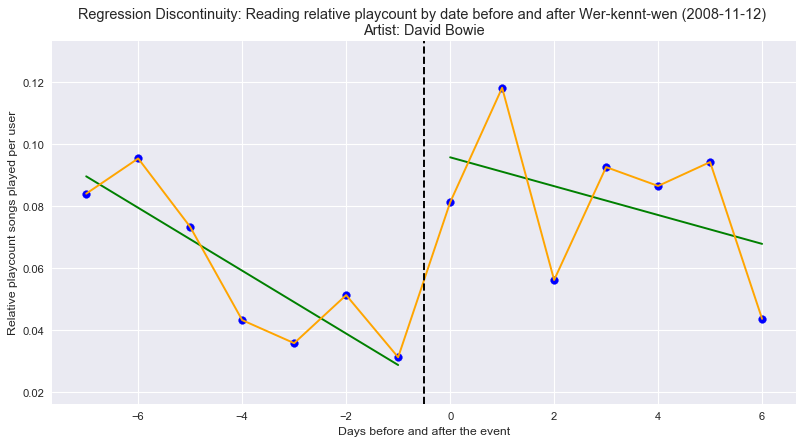


---------------------------------------------------------

R-squared: 0.467949697184

---------------------------------------------------------

Parameters

Intercept                  0.056797
threshold                 -0.044060
days_to_event              0.005185
threshold:days_to_event    0.000551
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.000853
threshold                  0.017754
days_to_event              0.084467
threshold:days_to_event    0.888357
dtype: float64

---------------------------------------------------------



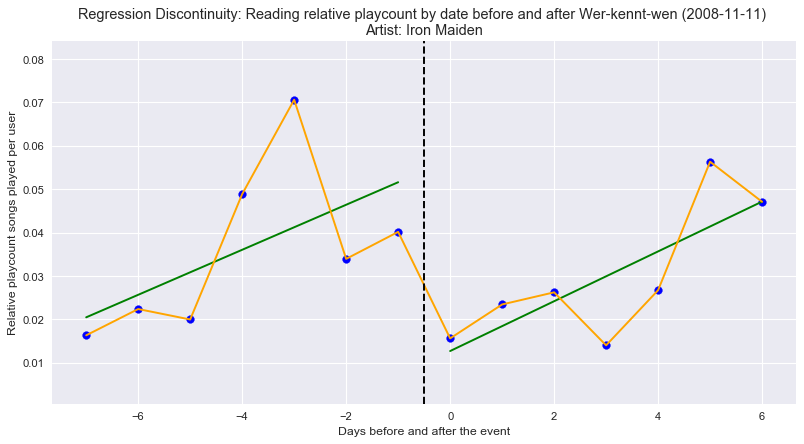


---------------------------------------------------------

R-squared: 0.498401693404

---------------------------------------------------------

Parameters

Intercept                 -0.012728
threshold                  0.047418
days_to_event             -0.009373
threshold:days_to_event    0.006541
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.381714
threshold                  0.024154
days_to_event              0.013041
threshold:days_to_event    0.167846
dtype: float64

---------------------------------------------------------



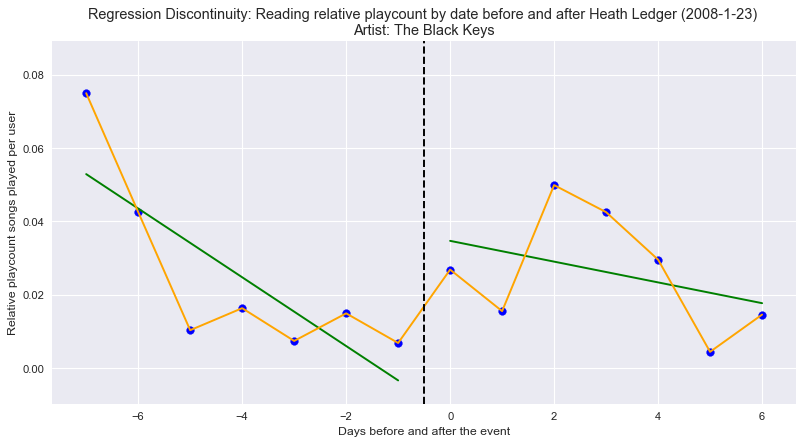


---------------------------------------------------------

R-squared: 0.603233873758

---------------------------------------------------------

Parameters

Intercept                  0.430012
threshold                 -0.375033
days_to_event              0.058317
threshold:days_to_event   -0.049322
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.001430
threshold                  0.012227
days_to_event              0.020326
threshold:days_to_event    0.147778
dtype: float64

---------------------------------------------------------



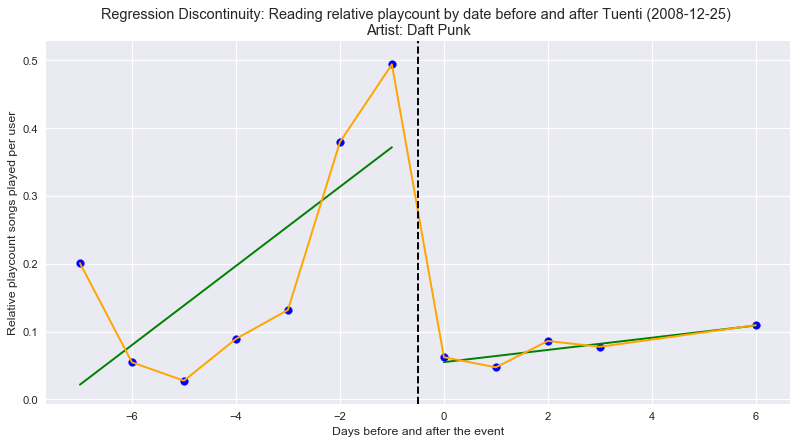


---------------------------------------------------------

R-squared: 0.614466904471

---------------------------------------------------------

Parameters

Intercept                  0.007099
threshold                  0.040915
days_to_event             -0.009175
threshold:days_to_event    0.010212
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.523675
threshold                  0.014164
days_to_event              0.003377
threshold:days_to_event    0.013205
dtype: float64

---------------------------------------------------------



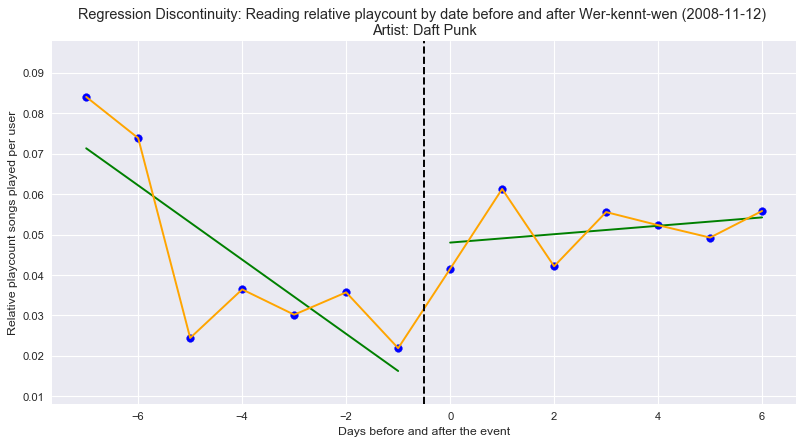


---------------------------------------------------------

R-squared: 0.341695734202

---------------------------------------------------------

Parameters

Intercept                  0.096985
threshold                 -0.056727
days_to_event              0.006045
threshold:days_to_event    0.000585
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.000598
threshold                  0.048682
days_to_event              0.199568
threshold:days_to_event    0.926927
dtype: float64

---------------------------------------------------------



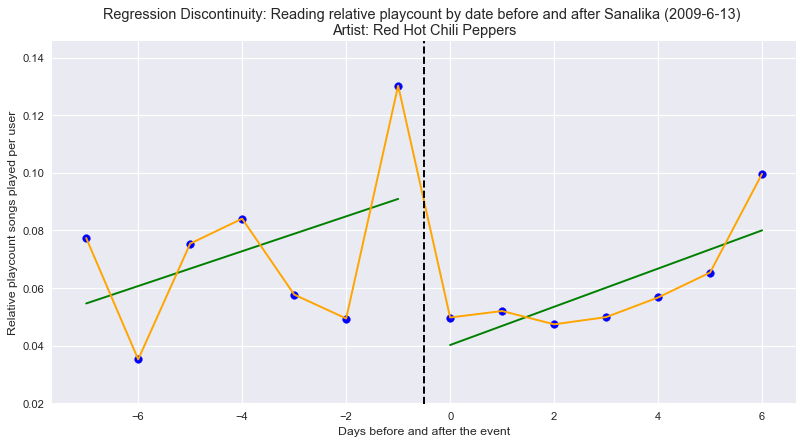


---------------------------------------------------------

R-squared: 0.670552157762

---------------------------------------------------------

Parameters

Intercept                  0.110105
threshold                 -0.088593
days_to_event              0.012637
threshold:days_to_event   -0.012639
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.000129
threshold                  0.003664
days_to_event              0.011466
threshold:days_to_event    0.053835
dtype: float64

---------------------------------------------------------



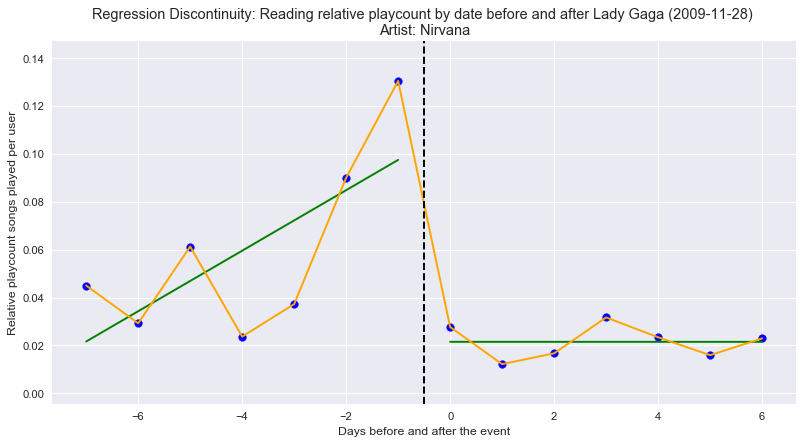


---------------------------------------------------------

R-squared: 0.687609231213

---------------------------------------------------------

Parameters

Intercept                  0.046524
threshold                  0.083966
days_to_event              0.003964
threshold:days_to_event   -0.025473
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.081311
threshold                  0.021438
days_to_event              0.477100
threshold:days_to_event    0.007292
dtype: float64

---------------------------------------------------------



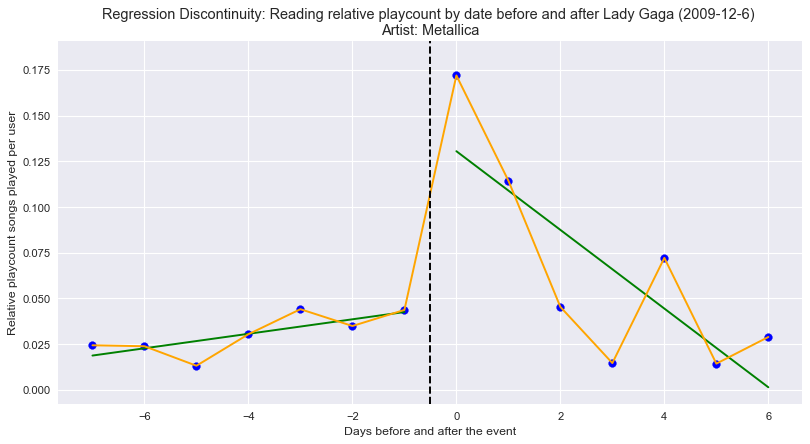


---------------------------------------------------------

R-squared: 0.605174543541

---------------------------------------------------------

Parameters

Intercept                  0.043320
threshold                  0.098734
days_to_event             -0.002007
threshold:days_to_event   -0.017007
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.123106
threshold                  0.013625
days_to_event              0.734412
threshold:days_to_event    0.063073
dtype: float64

---------------------------------------------------------



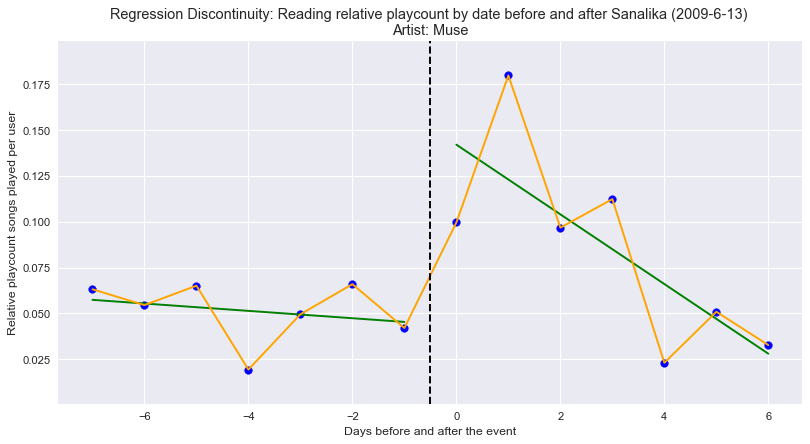


---------------------------------------------------------

R-squared: 0.560188822051

---------------------------------------------------------

Parameters

Intercept                  0.012396
threshold                  0.088661
days_to_event             -0.011454
threshold:days_to_event    0.008990
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.576980
threshold                  0.009324
days_to_event              0.038433
threshold:days_to_event    0.215521
dtype: float64

---------------------------------------------------------



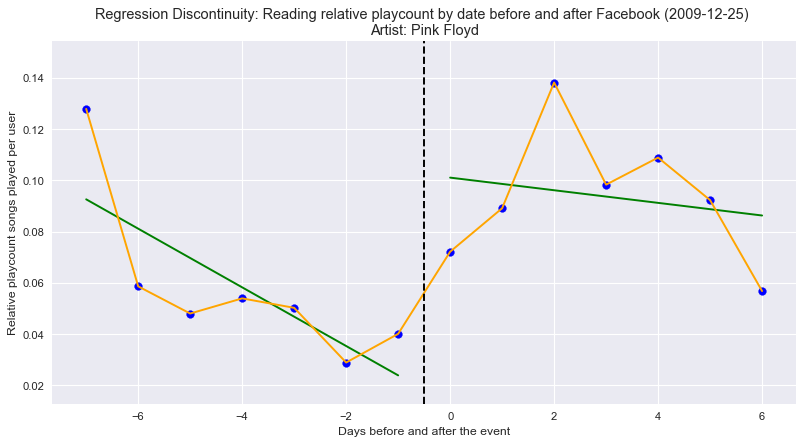


---------------------------------------------------------

R-squared: 0.560188822051

---------------------------------------------------------

Parameters

Intercept                  0.012396
threshold                  0.088661
days_to_event             -0.011454
threshold:days_to_event    0.008990
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.576980
threshold                  0.009324
days_to_event              0.038433
threshold:days_to_event    0.215521
dtype: float64

---------------------------------------------------------



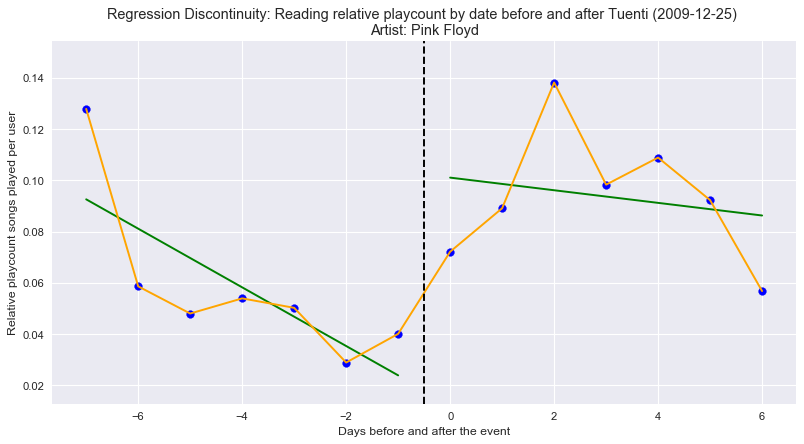


---------------------------------------------------------

R-squared: 0.560188822051

---------------------------------------------------------

Parameters

Intercept                  0.012396
threshold                  0.088661
days_to_event             -0.011454
threshold:days_to_event    0.008990
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.576980
threshold                  0.009324
days_to_event              0.038433
threshold:days_to_event    0.215521
dtype: float64

---------------------------------------------------------



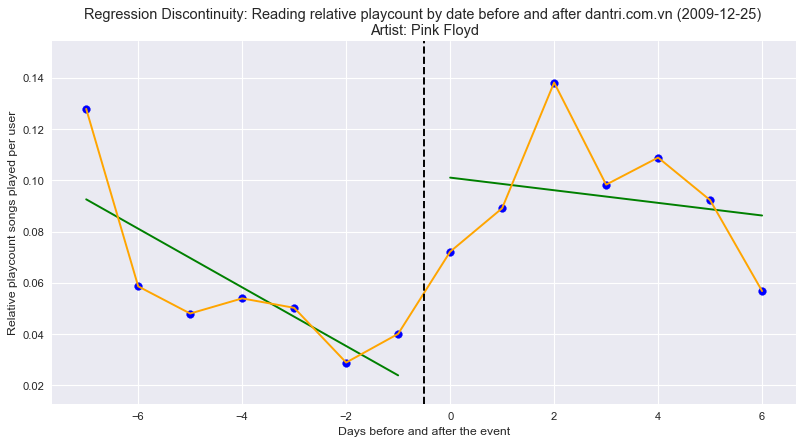


---------------------------------------------------------

R-squared: 0.394129552102

---------------------------------------------------------

Parameters

Intercept                  0.045352
threshold                 -0.028896
days_to_event              0.002635
threshold:days_to_event   -0.000458
dtype: float64

---------------------------------------------------------

P-values

Intercept                  0.000736
threshold                  0.038911
days_to_event              0.241812
threshold:days_to_event    0.881362
dtype: float64

---------------------------------------------------------



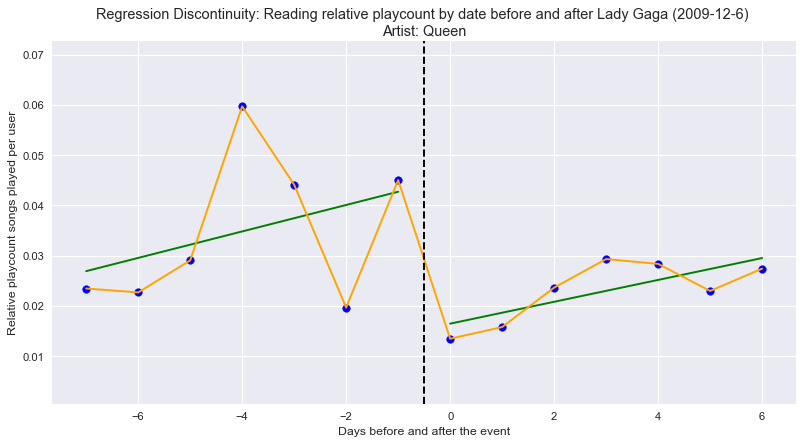

In [ ]:
artist_list = list(set(list(DF.artist)))

for year in list(set(DF['year'])):
    
    for artist in artist_list:
        
        df_focus = DF[((DF.year == year) & (DF.artist == artist))]
    

        for index, row in events_filtered.iterrows():
            if row.year == year:
                dateEvent = row.date
                dateBefore = row.date - timedelta(days=N)
                dateAfter = row.date + timedelta(days=N)

                def threshold(size):
                    if(size>=dateEvent):
                        return 1
                    return 0

                def days_to_event(size):
                    delta = size - dateEvent
                    return delta.days

                def linear_decrease_from_event(size):
                    delta = size - dateEvent
                    if delta.days < 0:
                        return 0
                    else:
                        value = 7 - delta.days
                        return value

                def exp_decrease_from_event(size):
                    delta = size - dateEvent
                    if delta.days < 0:
                        return 0
                    else:
                        value = 49 - math.pow(delta.days, 2)
                        return value

                # ONLY FOR X DAYS BEFORE AND AFTER THE EVENT
                data = df_focus[(df_focus.index < dateAfter) & (df_focus.index >= dateBefore)]

                # WHEN THE FILTERING RETURNS AN EMPTY DATAFRAME => CONTINUE
                if data.empty or len(list(data.relative_play)) < 12:
                    continue

                data['threshold'] = data.index.map(threshold)
                data['days_to_event'] = data.index.map(days_to_event)
                data['linear_decrease_after_event'] = data.index.map(linear_decrease_from_event)
                data['exp_decrease_after_event'] = data.index.map(exp_decrease_from_event)

                result = sm.ols(formula="relative_play ~ threshold + days_to_event + threshold * days_to_event", data=data).fit()

                # If sinificant, plot lines
                if result.pvalues['threshold'] <0.05:

                    #print(result.summary())
                    print('')
                    print('---------------------------------------------------------')
                    print('')

                    print('R-squared: %s' % result.rsquared)

                    print('')
                    print('---------------------------------------------------------')
                    print('')
                    print('Parameters')
                    print('')
                    print(result.params)
                    print('')
                    print('---------------------------------------------------------')
                    print('')
                    print('P-values')
                    print('')
                    print(result.pvalues)
                    print('')
                    print('---------------------------------------------------------')
                    print('')

                    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
                    plt.scatter(data.days_to_event,data.relative_play, color="blue")
                    plt.plot(data.days_to_event[:7], result.predict()[:7], '-', color='green')
                    plt.plot(data.days_to_event[7:], result.predict()[7:], '-', color='green')
                    plt.plot(data.days_to_event, data.relative_play, '-', color='orange')
                    plt.axvline(x=-0.5,color="black", linestyle="--")
                    plt.xlabel('Days before and after the event')
                    plt.ylabel('Relative playcount songs played per user')
                    plt.title("Regression Discontinuity: Reading relative playcount by date before and after " + str(row.description) + " (" + str(row.year) + '-'+ str(row.month) + '-'+ str(row.day) +") \n" + 'Artist: ' + str(artist) , fontsize="13")
                    #plt.savefig('../data/figures/RDD_' + str(row.description) + '_' + str(row.year) + '-'+ str(row.month) + '-'+ str(row.day) + '.png', dpi=300)
                    #plt.close()
                    plt.show()


There are some events for which a continuous line is noticable, but that are marked as discontinuous because of an effect at day 5, 6 or 7. Therefore we decide to perform a same analysis, but only consider the three days before and after the event instead of 7.

In [ ]:
N=3

artist_list = list(set(list(DF.artist)))

for year in list(set(DF['year'])):
    
    for artist in artist_list:
        
        df_focus = DF[((DF.year == year) & (DF.artist == artist))]
    

        for index, row in events_filtered.iterrows():
            if row.year == year:
                dateEvent = row.date
                dateBefore = row.date - timedelta(days=N)
                dateAfter = row.date + timedelta(days=N)

                def threshold(size):
                    if(size>=dateEvent):
                        return 1
                    return 0

                def days_to_event(size):
                    delta = size - dateEvent
                    return delta.days

                def linear_decrease_from_event(size):
                    delta = size - dateEvent
                    if delta.days < 0:
                        return 0
                    else:
                        value = 3 - delta.days
                        return value

                def exp_decrease_from_event(size):
                    delta = size - dateEvent
                    if delta.days < 0:
                        return 0
                    else:
                        value = 9 - math.pow(delta.days, 2)
                        return value

                # ONLY FOR X DAYS BEFORE AND AFTER THE EVENT
                data = df_focus[(df_focus.index < dateAfter) & (df_focus.index >= dateBefore)]

                # WHEN THE FILTERING RETURNS AN EMPTY DATAFRAME => CONTINUE
                if data.empty or len(list(data.relative_play)) < 12:
                    continue

                data['threshold'] = data.index.map(threshold)
                data['days_to_event'] = data.index.map(days_to_event)
                data['linear_decrease_after_event'] = data.index.map(linear_decrease_from_event)
                data['exp_decrease_after_event'] = data.index.map(exp_decrease_from_event)

                result = sm.ols(formula="relative_play ~ threshold + days_to_event + threshold * days_to_event", data=data).fit()
                
                print(result.summary())
                
                # If sinificant, plot lines
                if result.pvalues['threshold'] <0.05:

                    #print(result.summary())
                    print('')
                    print('---------------------------------------------------------')
                    print('')

                    print('R-squared: %s' % result.rsquared)

                    print('')
                    print('---------------------------------------------------------')
                    print('')
                    print('Parameters')
                    print('')
                    print(result.params)
                    print('')
                    print('---------------------------------------------------------')
                    print('')
                    print('P-values')
                    print('')
                    print(result.pvalues)
                    print('')
                    print('---------------------------------------------------------')
                    print('')

                    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
                    plt.scatter(data.days_to_event,data.relative_play, color="blue")
                    plt.plot(data.days_to_event[:7], result.predict()[:7], '-', color='green')
                    plt.plot(data.days_to_event[7:], result.predict()[7:], '-', color='green')
                    plt.plot(data.days_to_event, data.relative_play, '-', color='orange')
                    plt.axvline(x=-0.5,color="black", linestyle="--")
                    plt.xlabel('Days before and after the event')
                    plt.ylabel('Relative playcount songs played per user')
                    plt.title("Regression Discontinuity: Reading relative playcount by date before and after " + str(row.description) + " (" + str(row.year) + '-'+ str(row.month) + '-'+ str(row.day) +") \n" + 'Artist: ' + str(artist) , fontsize="13")
                    #plt.savefig('../data/figures/RDD_' + str(row.description) + '_' + str(row.year) + '-'+ str(row.month) + '-'+ str(row.day) + '.png', dpi=300)
                    #plt.close()
                    plt.show()

